# Importing Libraries

In [2]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from scipy.fftpack import dct,idct

# Problem 1

In [3]:
image = skimage.io.imread('cameraman.tif')

In [4]:
# Define quantization matrix
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

In [6]:
def Quantized_Image(image: np.ndarray, Q: float) -> np.ndarray:
    """
    Applies quantization to an image using the discrete cosine transform (DCT) algorithm.

    Parameters:
        image (np.ndarray): The input image as a numpy array.
        Q (float): The quantization factor.

    Returns:
        quantized_image (np.ndarray): The quantized image as a numpy array.
    """

    # Get the height and width of the input image
    height, width = image.shape

    # Create an empty numpy array to store the quantized image
    quantized_image = np.zeros((height, width))

    # Apply DCT to each 8x8 block of the input image and quantize the coefficients
    for i in range(height // 8):
        for j in range(width // 8):
            # Get the 8x8 block of the input image
            block = image[i * 8:(i + 1) * 8, j * 8:(j + 1) * 8]

            # Apply the DCT algorithm to the block and normalize it
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')

            # Quantize the DCT coefficients of the block and round them to the nearest integer
            quantized_block = np.floor(dct_block / Q + 0.5)

            # Store the quantized block in the quantized image
            quantized_image[i * 8:(i + 1) * 8, j * 8:(j + 1) * 8] = quantized_block

    # Return the quantized image
    return quantized_image


In [7]:
def encoded_bit_length(n: int) -> int:
    """
    Calculates the number of bits required to represent an integer in run-length encoding.

    Parameters:
        n (int): The integer to be encoded.

    Returns:
        bit_length (int): The number of bits required to represent the integer in run-length encoding.
    """

    # If the integer is 0, return 1 bit
    if n == 0:
        return 1

    # Calculate the number of bits required to represent the absolute value of the integer
    bit_length = int(np.log2(abs(n))) + 1

    # Return the number of bits required to represent the integer in run-length encoding
    return bit_length * 2 + 1

In [8]:
def total_encoded_bit_length(quantized_image: np.ndarray) -> int:
    """
    Calculates the total number of bits required to represent a quantized image in run-length encoding.

    Parameters:
        quantized_image (np.ndarray): The quantized image as a numpy array.

    Returns:
        bit_length (int): The total number of bits required to represent the quantized image in run-length encoding.
    """

    # Initialize the bit length to zero
    bit_length = 0

    # Loop through each element of the quantized image and calculate the number of bits required to represent it in run-length encoding
    for i in range(quantized_image.shape[0]):
        for j in range(quantized_image.shape[1]):
            bit_length += encoded_bit_length(quantized_image[i][j])

    # Return the total number of bits required to represent the quantized image in run-length encoding
    return bit_length



In [9]:
def Reconstruct_image(quantized_image: np.ndarray, Q: float) -> np.ndarray:
    """
    Reconstructs the original image from a quantized image using inverse discrete cosine transform (IDCT).

    Parameters:
        quantized_image (np.ndarray): The quantized image as a numpy array.
        Q (float): The quantization factor used to quantize the image.

    Returns:
        reconstructed_image (np.ndarray): The reconstructed image as a numpy array.
    """

    # Initialize the reconstructed image as an array of zeros with the same shape as the quantized image
    reconstructed_image = np.zeros(quantized_image.shape)

    # Get the height and width of the quantized image
    height, width = quantized_image.shape

    # Loop through each 8x8 block of the quantized image and reconstruct the corresponding 8x8 block of the original image using IDCT
    for i in range(height//8):
        for j in range(width//8):
            reconstructed_image[i*8:(i+1)*8, j*8:(j+1)*8] = idct(idct((quantized_image[i*8:(i+1)*8, j*8:(j+1)*8]*Q).T, norm='ortho').T, norm='ortho')

    # Return the reconstructed image
    return reconstructed_image


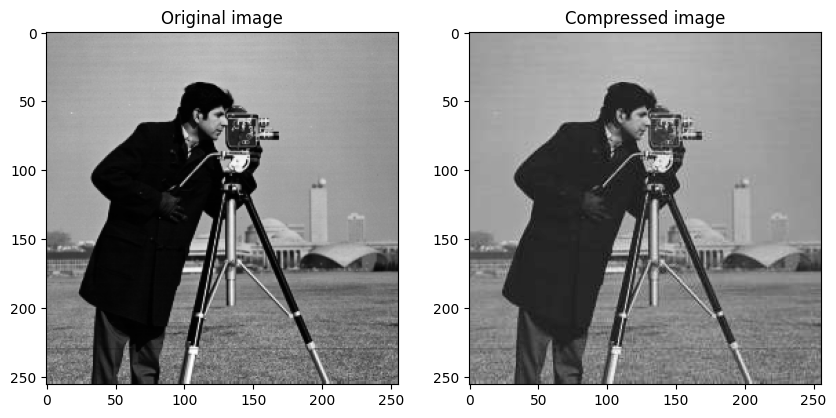

In [10]:
qunatized_image = Quantized_Image(image,Q)
compressed_image = Reconstruct_image(qunatized_image,Q)
image_size = image.size*image.itemsize*8
compressed_image_size = total_encoded_bit_length(qunatized_image) 
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.title("Original image")
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Compressed image")
plt.imshow(compressed_image, cmap='gray')
plt.show()

In [13]:
print("MSE:",np.mean((image-compressed_image)**2))
print(f'Size Input Image(Kb):{image_size/(8*1024)}')
print(f'Size Compressed Image(kb):{compressed_image_size/(8*1024)}')
print(f'Compression Ratio:{image_size/compressed_image_size}')

MSE: 44.54563508062465
Size Input Image(Kb):64.0
Size Compressed Image(kb):13.214599609375
Compression Ratio:4.84312819849613


In [71]:
def decrease_Q(image,Q):
    MSE_list = [] 
    file_size=[]
    compression_ratio_list = []
    for i in np.arange(1,100):
        scaled_Q = np.ceil(Q/i)
        quantized_image = Quantized_Image(image,scaled_Q)
        compressed_image = Reconstruct_image(quantized_image,scaled_Q)
        compressed_bits = total_encoded_bit_length(quantized_image)
        file_size.append(compressed_bits/(1024*1024*8))
        MSE_list.append(np.mean((image-compressed_image)**2))
        compression_ratio_list.append(image_size/compressed_bits)

    return MSE_list , file_size , compression_ratio_list

def increase_Q(image,Q):
    MSE_list = [] 
    file_size=[]
    compression_ratio_list = []
    for i in np.arange(1,100):
        scaled_Q = Q*i
        quantized_image = Quantized_Image(image,scaled_Q)
        compressed_image = Reconstruct_image(quantized_image,scaled_Q)
        compressed_bits = total_encoded_bit_length(quantized_image)
        file_size.append(compressed_bits/(1024*1024*8))
        MSE_list.append(np.mean((image-compressed_image)**2))
        compression_ratio_list.append(image_size/compressed_bits)

    return MSE_list , file_size , compression_ratio_list

In [72]:
mse_d, size_d , ratios_d = decrease_Q(image,Q)
mse_i, size_i , ratios_i = increase_Q(image,Q)

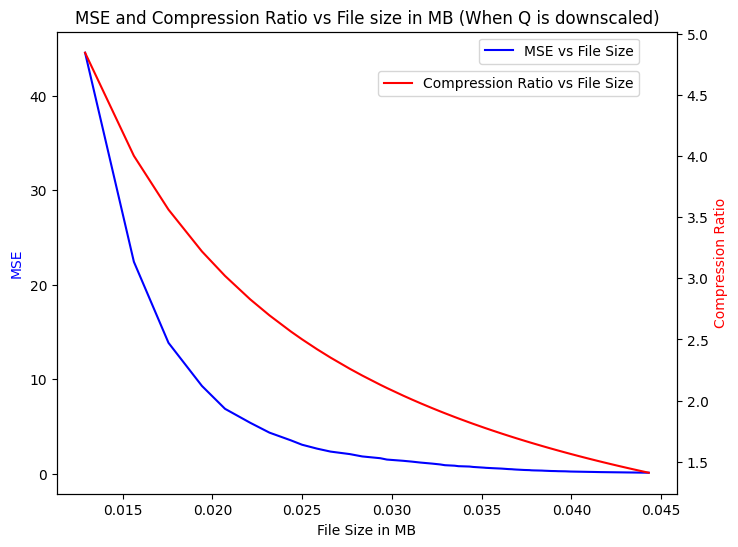

In [73]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(8,6))

# Plot first dataset on the first axis
ax1.plot(size_d, mse_d, 'b-',label = 'MSE vs File Size')
ax1.set_xlabel('File Size in MB')
ax1.set_ylabel('MSE', color='b')

# Create a second axis object and plot second dataset on it
ax2 = ax1.twinx()
ax2.plot(size_d, ratios_d, 'r-',label = 'Compression Ratio vs File Size')
ax2.set_ylabel('Compression Ratio', color='r')

# Show the plot
ax1.legend(loc='upper right', bbox_to_anchor=(0.95, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(0.95, 0.93))
plt.title('MSE and Compression Ratio vs File size in MB (When Q is downscaled)')
plt.show()

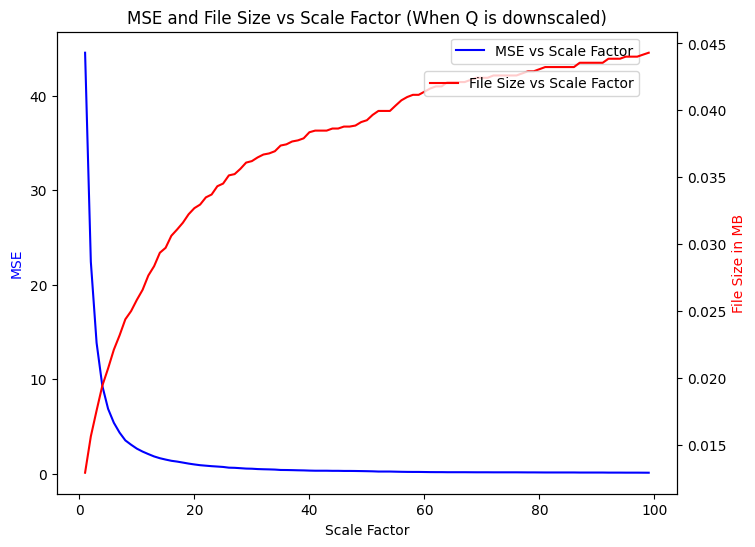

In [74]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(8,6))

# Plot first dataset on the first axis
ax1.plot(np.arange(1,100), mse_d, 'b-',label = 'MSE vs Scale Factor')
ax1.set_xlabel('Scale Factor')
ax1.set_ylabel('MSE', color='b')

# Create a second axis object and plot second dataset on it
ax2 = ax1.twinx()
ax2.plot(np.arange(1,100), size_d, 'r-',label = 'File Size vs Scale Factor')
ax2.set_ylabel('File Size in MB', color='r')

# Show the plot
ax1.legend(loc='upper right', bbox_to_anchor=(0.95, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(0.95, 0.93))
plt.title('MSE and File Size vs Scale Factor (When Q is downscaled)')
plt.show()

Text(0.5, 1.0, 'Compression Ratio vs Scale Factor (When Q is downscaled)')

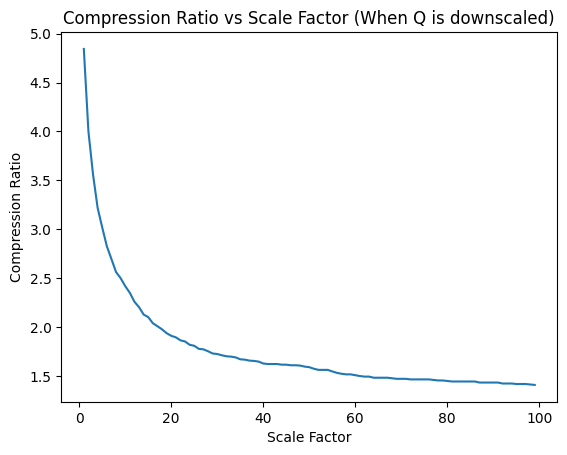

In [75]:
plt.plot(np.arange(1,100),ratios_d)
plt.xlabel('Scale Factor')
plt.ylabel("Compression Ratio")
plt.title('Compression Ratio vs Scale Factor (When Q is downscaled)')

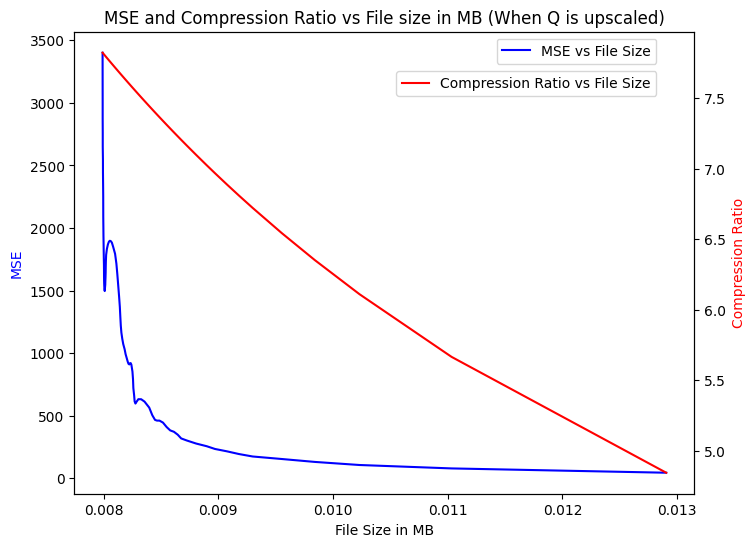

In [76]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(8,6))

# Plot first dataset on the first axis
ax1.plot(size_i, mse_i, 'b-',label = 'MSE vs File Size')
ax1.set_xlabel('File Size in MB')
ax1.set_ylabel('MSE', color='b')

# Create a second axis object and plot second dataset on it
ax2 = ax1.twinx()
ax2.plot(size_i, ratios_i, 'r-',label = 'Compression Ratio vs File Size')
ax2.set_ylabel('Compression Ratio', color='r')

# Show the plot
ax1.legend(loc='upper right', bbox_to_anchor=(0.95, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(0.95, 0.93))
plt.title('MSE and Compression Ratio vs File size in MB (When Q is upscaled)')
plt.show()

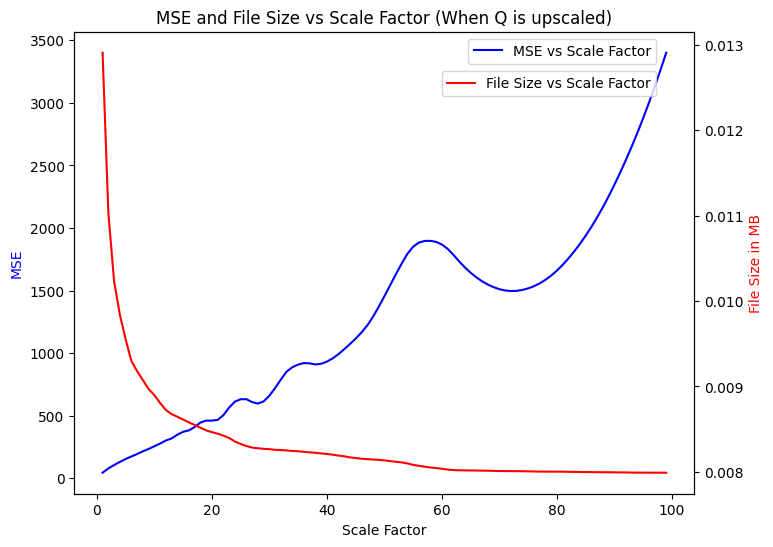

In [77]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(8,6))

# Plot first dataset on the first axis
ax1.plot(np.arange(1,100), mse_i, 'b-',label = 'MSE vs Scale Factor')
ax1.set_xlabel('Scale Factor')
ax1.set_ylabel('MSE', color='b')

# Create a second axis object and plot second dataset on it
ax2 = ax1.twinx()
ax2.plot(np.arange(1,100), size_i, 'r-',label = 'File Size vs Scale Factor')
ax2.set_ylabel('File Size in MB', color='r')

# Show the plot
ax1.legend(loc='upper right', bbox_to_anchor=(0.95, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(0.95, 0.93))
plt.title('MSE and File Size vs Scale Factor (When Q is upscaled)')
plt.show()

Text(0.5, 1.0, 'Compression Ratio vs Scale Factor (When Q is upscaled)')

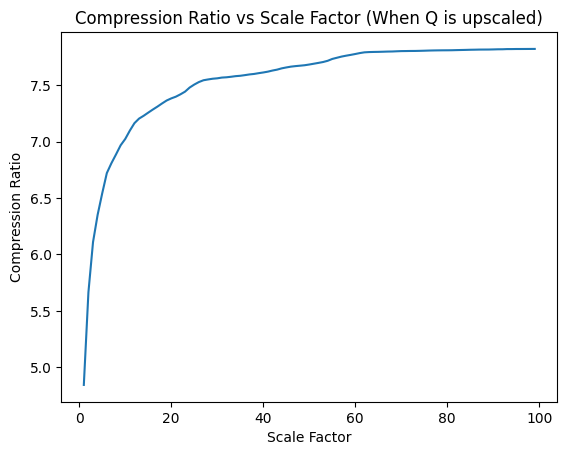

In [78]:
plt.plot(np.arange(1,100),ratios_i)
plt.xlabel('Scale Factor')
plt.ylabel("Compression Ratio")
plt.title('Compression Ratio vs Scale Factor (When Q is upscaled)')